TRIPPy examples
========

Introduction: SExtractor and emcee
--------------------------------

To perform photometry and source subtraction, in addition to having a good PSF (which trippy will generate) one needs three very important parameters: x, y, and m, or source position and amplitude. 

When one has the PSF and TSF already generated, one can run a fitting routine to solve for these. For this purpose, we use [emcee.](https://github.com/dfm/emcee) *emcee* is an MCMC routine which allows for good estimates of (x,y,m) and their uncertainties. We use a likelihood definition as the natural log likelihood of the exponential flux, basically exactly what you'd expect. If you are uncertain of what this means, or care for more detail, please go read the *emcee* documentation.

If the PSF or TSF is not yet known, to get a centroid (x,y), we need to use some other software. We haven't included this inside trippy because there is no point in reinventing a wheel that has already been nearly perfected. For this purpose, we use the venerable [SExtractor.](http://www.astromatic.net/software/sextractor) All jokes on its name aside, *sextractor* does exactly what we need, as well as we would ever need it to be done. 

Trippy includes a module *trippy.scamp* with functions defined in *scamp.py* and *makeParFiles.py* that mearly provide convenient wrappers to call *sextractor*. This has been done in a couple other packages, but not in a way that satisfies me. Hence my own implementation. A couple details to note: makeParFiles creates all the parameter files in the working directory (eg. *makeParFiles.writeConv()*), and scamp is responsible for *sextractor* execution and catalog reading (*scamp.runSex()* and *scamp.getCatalog*). Catalogs are stored in FITS_LDAC format. This choice was done to facilitate execution of the *sextractor* sister program *scamp*, though we won't need to know what that means for full use of trippy. If you are unfamiliar with *sextractor* and its use, don't adopt trippy as a blackbox. [RTFM!](http://www.starlink.rl.ac.uk/docs/sun226.htx/mud165.pdf)

With that out of the way, on to actual business.


The *trippy* tutorial
------------------

The first thing to do is import all the necessary packages. Note that this notebook assumes you have the optional packages installed, as well as SExtractor available on your command line.

**NOTE: proper use of psfStarChooser requires plot interaction. So for this tutorial you'd best comment out the first line, %matplotlib inline. But for my web presentation, I leave inline.**

In [1]:
#%matplotlib inline
import numpy as num, astropy.io.fits as pyf,pylab as pyl
from trippy import psf, pill, psfStarChooser, tzscale
from trippy import scamp,MCMCfit
import scipy as sci
from os import path
import os
from astropy.visualization import interval

The function trim catalog is a convenience function to simply return only those sources that are well enough isolated for PSF generation. It rejects any sources within 30 pixels of another source, any sources with peak pixel above 70,000, and any sources that sextractor has flagged **for what ever reason**. We may fold this into psfStarChooser in the future.


In [2]:
def trimCatalog(cat):
    good=[]
    for i in range(len(cat['XWIN_IMAGE'])):
        try:
            a = int(cat['XWIN_IMAGE'][i])
            b = int(cat['YWIN_IMAGE'][i])
            m = num.max(data[b-4:b+5,a-4:a+5])
        except: pass
        dist = num.sort(((cat['XWIN_IMAGE']-cat['XWIN_IMAGE'][i])**2+(cat['YWIN_IMAGE']-cat['YWIN_IMAGE'][i])**2)**0.5)
        d = dist[1]
        if cat['FLAGS'][i]==0 and d>30 and m<70000:
            good.append(i)
    good=num.array(good)
    outcat = {}
    for i in cat:
        outcat[i] = cat[i][good]
    return outcat

Get the image this tutorial assumes you have. If wget fails then you are likely on a mac, and should just download it manually

In [3]:
inputFile='Polonskaya.fits'
if not path.isfile(inputFile):
    os.system('wget -O Polonskaya.fits http://www.canfar.phys.uvic.ca/vospace/nodes/fraserw/Polonskaya.fits?view=data')
else:
    print("We already have the file.")
    

We already have the file.


First load the fits image and get out the header, data, and exposure time.

In [4]:
with pyf.open(inputFile) as han:
    data = han[0].data
    header = han[0].header
    EXPTIME = header['EXPTIME']

Next run sextractor on the images, and use trimCatalog to create a trimmed down list of isolated sources. 

makeParFiles handles the creation of all the sextractor files, including the .sex file which we call example.sex, the default.conv, the param file which is saved as def.param.

.runSex creates example.cat which is read by .getCatalog. getCatalog takes as input the catalog name and the parameter file "def.param".

The parameters that are actually used by psfStarChooser and psf.genLookupTable are XWIN_IMAGE, YWIN_IMAGE, FLUX_AUTO, and FLUXERR_AUTO, which are the x,y coordinates, the flux, and the flux uncertainty estimate respectively. The latter two are used in the SNR cut that psfStarChooser makes.

In [5]:
scamp.makeParFiles.writeSex('example.sex',
                    minArea=3.,
                    threshold=5.,
                    zpt=27.8,
                    aperture=20.,
                    min_radius=2.0,
                    catalogType='FITS_LDAC',
                    saturate=55000)
scamp.makeParFiles.writeConv()
scamp.makeParFiles.writeParam(numAps=1) #numAps is thenumber of apertures that you want to use. Here we use 1

scamp.runSex('example.sex', inputFile ,options={'CATALOG_NAME':'example.cat'},verbose=False)
catalog = trimCatalog(scamp.getCatalog('example.cat',paramFile='def.param'))

Finally, find the source closest to 811, 4005 which is the bright asteroid, 2006 Polonskaya. Also, set the rate and angle of motion. These were found from JPL horizons. The 1 degree increase is to account for the slight rotation of the image.

Note: in this image, the asteroid is near (4005,811) and we apply a distance sort to the catalog to find correct catalog entry, and the source centroid, which we store in (xt,yt).

Setting the important asteroid parameters. xt,yt contain the location of the asteroid itself (near 811,4005), rate and angle are the rate and angle of traililng, in "/hr and degrees. We find the actual centroid as the location closest to that point.

In [6]:
dist = ((catalog['XWIN_IMAGE']-811)**2+(catalog['YWIN_IMAGE']-4005)**2)**0.5
args = num.argsort(dist)
xt = catalog['XWIN_IMAGE'][args][0]
yt = catalog['YWIN_IMAGE'][args][0]

rate = 18.4588 # "/hr
angle = 31.11+1.1 # degrees counter clockwise from horizontal, right

Now use psfStarChooser to select the PSF stars. The first and second parameters to starChooser are the fitting box width in pixels, and the SNR minimum required for a star to be considered as a potential PSF star. 

Optional but important inputs are autoTrim and noVisualSelection. The former, when True, uses bgFinder.fraserMode to attempt to determine what FWHM corresponds to actual stars, and rejects all sources with FWHM outside +-0.5 pixels of the modal value. noVisualSelection determines if manual input is required. When set to false, all stars are considered. **Until you know the software, I suggest you use noVisualSelection=True for manual selection, and autoTrim=False to see all sources in the plot window.**

For each star provided to psfStarChooser, it will print a line to screen of x,y and best fit alpha, beta, and FWHM of the moffat profile fit.

Then psfStarChooser will pop-up a multipanel window. **Top left:** histogram of fit chi values. **Top right:** chi vs. FWHM for each fitted source. **Middle right:** histogram of FWHM. **Bottom right:** image display of the currently selected source. **Bottom left:** Radial profiles of all sources displayed in the top right scatter plot.

The point of this window is to select only good stars for PSF generation, done by zooming to the good sources, and rejecting those that are bad.

Use the zoom tool to select the region containing the stars. In this image, that's a cluser at FWHM~3.5 pixels.

Left and right clicks will select a source, now surrounded by a diamond, displaying the radial profile bottom left, and the actual image bottom right.

Right click will oscillate between accepted source and rejected source (blue and red respectively). 

**Keyboard funcitonality is now also implemented. Use the left/right arrow keys (or a/d) to cycle through each source, and the up/down keys (or w/d) to mark a source as rejected (red) or accepted (blue).** This is probably the fastest way to cycle through sources. *Note that for some mac python installs, key presses won't be recognized inside a pylab window. To solve this, invoke your trippy script with pythonw instead of python.*

When the window is closed, only those sources shown as blue points, and within the zoom of the top right plot will be used to generate the PSF.

The array goodFits is returned for convenience and contains the moffat fit details of each accepted source. Each entry is [FWHM, chi, alpha, beta, x, y, local background value].

The array goodMeds is just the median of goodFits, and provides the median moffat alpha and beta of the selected stars.

Note on a couple starChooser options: 

--bgRadius is the radius outside of which the image background level is sampled. The fitting is relatively insensitive to this value, however, if you happen to know what the FWHM is approximately, then the best fitting results can be had with bgRadius>~3xFWHM in pixels.

--ftol is the least squares fitting tolerance parameter passed to the scipy least sqaures fitter. Increasing this number can result in dramatic performance improvements. Default is 1.4e-8 to provide an extremely accurate fit. Good enough fits can be had with 1.e-7 or even 1.e-6 if one has a need for speed.

--repFact defaults to 5. If you want to run faster but still preserve most accuracy in the fitting procedure, use repFact = 3

--quickFit = True will provide the fastest moffat fitting. The speed improvement over quickFit = False is dramatic, but results in slightly less accurate moffat fit parameters. For the majority of use cases, where the number of good psf stars are more than a few, the degredation in PSF accuracy will not be appreciable because of the fact that a lookup table is used. But the user should confirm this be comparing PSFs generated in both circumstances.

Fitting stars with moffat profiles...
      X         Y    chi    a     b    FWHM
    1657.51   157.63 73.05  15.16  2.45  17.36 
    1009.42   363.71 0.22  2.84  2.56  3.17 
     251.90   684.70 0.24  2.86  2.59  3.17 
    1211.61   936.20 0.22  3.23  1.59  4.78 
    1587.22   945.88 0.12  2.68  2.36  3.13 
    1081.55   914.77 0.21  2.77  2.49  3.15 
    1315.03  1023.28 0.17  2.84  2.58  3.16 
    1652.57  1014.63 0.17  2.78  2.53  3.12 
     383.82  1238.34 0.20  2.90  2.63  3.19 
    1241.75  1286.83 0.53  3.58  2.27  4.27 


/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 250.
  warnings.warn(errors[info][0], RuntimeWarning)


     510.65  1902.63 67.89  15.30  2.04  19.50 
    1106.80  2196.58 0.19  2.88  2.59  3.20 
     855.31  2362.30 0.18  3.00  2.70  3.24 
    1606.23  2700.56 0.25  2.77  2.53  3.12 
     433.79  2761.05 0.17  2.94  2.63  3.23 
    1458.17  3023.19 10.96  7.85  2.68  8.53 
    1071.70  3291.51 0.25  2.91  2.65  3.19 
    1633.35  3827.17 0.18  2.96  2.69  3.22 
     357.50  3746.18 0.16  2.90  2.63  3.19 
    1269.99  4429.10 0.26  2.86  2.55  3.20 
    1483.94  4477.91 0.29  2.96  2.68  3.22 
     820.38  4243.44 0.17  2.84  2.56  3.18 
    1919.63  4017.65 0.25  2.93  2.68  3.19 
     294.44  4080.45 0.19  2.66  2.32  3.14 
     812.20  4004.29 7.49  5.60  2.51  6.33 
    1635.10  3908.77 0.23  3.41  1.44  5.38 

Doing auto star selection.


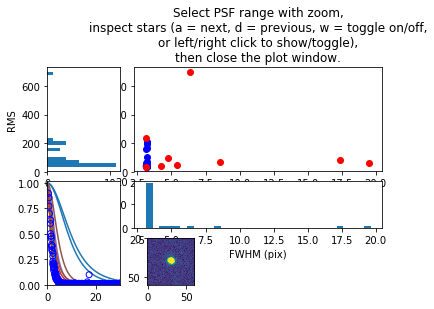

[[3.17000000e+00 4.16144249e+01 2.84227238e+00 2.56096442e+00
  1.00941845e+03 3.63707502e+02 1.21819794e+03]
 [3.17000000e+00 3.55619866e+01 2.85898488e+00 2.59391883e+00
  2.51904915e+02 6.84704324e+02 1.20387501e+03]
 [3.15000000e+00 3.96259866e+01 2.77353669e+00 2.48730275e+00
  1.08155135e+03 9.14770754e+02 1.22451532e+03]
 [3.16000000e+00 1.55846886e+02 2.84205062e+00 2.57704741e+00
  1.31503491e+03 1.02328459e+03 1.22901780e+03]
 [3.12000000e+00 6.28433553e+01 2.77870776e+00 2.53265023e+00
  1.65257487e+03 1.01462975e+03 1.22730834e+03]
 [3.19000000e+00 4.81048539e+01 2.89508163e+00 2.62900222e+00
  3.83816005e+02 1.23834251e+03 1.21315248e+03]
 [3.20000000e+00 6.69983277e+01 2.88419374e+00 2.59493757e+00
  1.10680319e+03 2.19658165e+03 1.23222269e+03]
 [3.24000000e+00 2.07357200e+02 2.99534192e+00 2.70155825e+00
  8.55306404e+02 2.36229528e+03 1.23123005e+03]
 [3.12000000e+00 3.68984316e+01 2.77325263e+00 2.52678616e+00
  1.60622802e+03 2.70056419e+03 1.23215373e+03]
 [3.230000

In [7]:
starChooser=psfStarChooser.starChooser(data,
                                       catalog['XWIN_IMAGE'],catalog['YWIN_IMAGE'],
                                       catalog['FLUX_AUTO'],catalog['FLUXERR_AUTO'])
(goodFits,goodMeds,goodSTDs) = starChooser(30,200,noVisualSelection=False,autoTrim=True, 
                                           bgRadius=15, quickFit = False,
                                           repFact = 5, ftol=1.49012e-08)
print(goodFits)
print(goodMeds)

Generate the PSF. We want a 61 pixel wide PSF, adopt a repFactor of 10, and use the mean star fits chosen above.

**always use odd values for the dimensions. Even values (eg. 60 instead of 61) result in off centered lookup tables.**

Repfactors of 5 and 10 have been tested thoroughly. Larger is pointless, smaller is inaccurate. 5 is faster than 10, 10 is more accurate than 5.

The PSF has to be wide/tall enough to handle the trailing length and the seeing disk. For Polonskaya, the larger is trailing, at ~19"/hr*480s/3600/0.185"/pix = 14 pixels. Choose something a few times larger. Also, stick with odd width PSFs, as the even ones have some funny centroid stuff that I haven't fully sorted out.

The full PSF is created with instantiation, and running both genLookupTable and genPSF.

Full width at half maximum 3.170 (in pix).


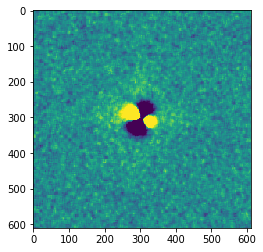

In [8]:
goodPSF = psf.modelPSF(num.arange(61),num.arange(61), alpha=goodMeds[2],beta=goodMeds[3],repFact=10)
goodPSF.genLookupTable(data,goodFits[:,4],goodFits[:,5],verbose=False)
fwhm = goodPSF.FWHM() ###this is the FWHM with lookuptable included
fwhm = goodPSF.FWHM(fromMoffatProfile=True) ###this is the pure moffat FWHM.

print("Full width at half maximum {:5.3f} (in pix).".format(fwhm))

(z1,z2) = tzscale.zscale(goodPSF.lookupTable)
normer = interval.ManualInterval(z1,z2)
pyl.imshow(normer(goodPSF.lookupTable))
pyl.show()

Now generate the TSF, which we call the line/long PSF interchangeably through the code...

Rate is in units of length/time and pixScale is in units of length/pixel, time and length are in units of your choice. Sanity suggests arcseconds and hours. Then rate in "/hr and pixScale in "/pix. Angle is in degrees counter clockwise from horizontal between +-90 degrees.

**This can be rerun to create a TSF with different rate/angle of motion, though keep in mind that the psf class only contains one longPSF (one rate/angle) at any given time.**

In [9]:
goodPSF.line(rate,angle,EXPTIME/3600.,pixScale=0.185,useLookupTable=True)

Using the lookup table when generating the line PSF.


Now calculate aperture corrections for the PSF and TSF. Store for values of r=1.4*FWHM.

Note that the precision of the aperture correction depends lightly on the sampling from the compute functions. 10 is generally enough to preserve 1% precision in the .roundAperCorr() and lineAperCorr() functions which use linear interpolation to get the value one actually desires.

**NOTE: Set useLookupTable=False if one wants to calculate from the moffat profile alone. Generally, not accuarate for small apertures however.**

In [10]:
goodPSF.computeRoundAperCorrFromPSF(psf.extent(0.8*fwhm,4*fwhm,10),display=False,
                                                          displayAperture=False,
                                                          useLookupTable=True)
roundAperCorr = goodPSF.roundAperCorr(1.4*fwhm)

goodPSF.computeLineAperCorrFromTSF(psf.extent(0.1*fwhm,4*fwhm,10),
                                                         l=(EXPTIME/3600.)*rate/0.185,a=angle,display=False,displayAperture=False)
lineAperCorr = goodPSF.lineAperCorr(1.4*fwhm)
print(lineAperCorr,roundAperCorr)


/Users/fraserw/git/trippy/trippy/trippy_utils.py:84: RuntimeWarning: invalid value encountered in double_scalars
  self.m = (p2[1]-p1[1])/(p2[0]-p1[0])
/Users/fraserw/git/trippy/trippy/trippy_utils.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  self.m = (p2[1]-p1[1])/(p2[0]-p1[0])


    Radius  Flux      Magnitude
      0.32  10270.345   -10.029
      0.48  15150.562   -10.451
      0.72  22154.786   -10.864
      1.08  31351.856   -11.241
      1.63  41925.570   -11.556
      2.46  52717.398   -11.805
      3.71  60598.973   -11.956
      5.59  65057.698   -12.033
      8.42  67398.988   -12.072
     12.68  68592.482   -12.091
0.10455723627990388 0.17889568485100327


Store the PSF. In TRIPPy v1.0 we introduced a new psf save format which decreases the storage requirements by roughly half, at the cost of increase CPU time when restoring the stored PSF. The difference is that the moffat component of the PSF was originally saved in the fits file's first extension. This is no longer saved, as it's pretty quick to calculate. 

Default behaviour is the old PSF format, but the new format can be flagged with psfV2=True as shown below.

In [11]:
goodPSF.psfStore('psf.fits', psfV2=True)

If we've already done the above once, we could doing it again by restoring the previously constructed PSF by the following commented out code.

In [12]:
#goodPSF = psf.modelPSF(restore='psf.fits')

And we could generate a new line psf by recalling .line with a new rate and angle

In [13]:
#goodPSF.line(new_rate,new_angle,EXPTIME/3600.,pixScale=0.185,useLookupTable=True)

Now let's do some pill aperture photometry. Instantiate the class, then call the object you created to get photometry of Polonskaya. Again assume repFact=10.

pillPhot takes as input the same coordinates as outputted by sextractor.

First example is of a round star which I have manually taken the coordinates from above. Second example is for the asteroid itself.

**New feature!** The input radii can either be singletons like in the example below, or a numpy array of radii. If photometry of the same source using multiple radii are needed, the numpy array is much much faster than passing individual singletons.

enableBGselection=True will cause a popup display of the source, in which one can zoom to a section with no background source.

The detault background selection technique is "smart". See bgFinder documentation for what that means. If you want to change this away from 'fraserMode', take a look at the options in bgFinder.

display=True to see the image subsection

r is the radius of the pill, l is the length, a is the angle. Sky radius is the radius of a larger pill aperture. The pixels in this larger aperture, but outside the smaller aperture are ignored. Anything outside the larger pill, but inside +-width is used for background estimation.

Trimbghighpix is mostly made not important if mode=smart. But if you want to use a mean or median for some reason, then this value is used to reject pixels with values trimBGhighPix standard deviations above the mean of the cutout.

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Current background value: 1217.866


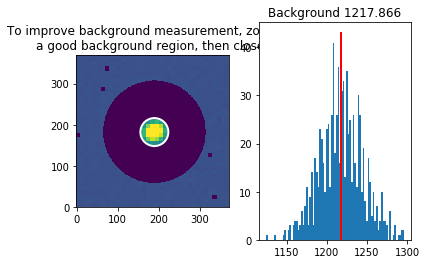

In [14]:
#initiate the pillPhot object
phot = pill.pillPhot(data,repFact=10)
#get photometry, assume ZPT=26.0
#enableBGselection=True allows you to zoom in on a good background region in the aperture display window
#trimBGhighPix is a sigma cut to get rid of the cosmic rays. They get marked as blue in the display window
#background is selected inside the box and outside the skyRadius value
#mode is th background mode selection. Options are median, mean, histMode (JJ's jjkmode technique), fraserMode (ask me about it), gaussFit, and "smart". Smart does a gaussian fit first, and if the gaussian fit value is discrepant compared to the expectation from the background std, it resorts to the fraserMode. "smart" seems quite robust to nearby bright sources

#examples of round sources
phot(goodFits[0][4], goodFits[0][5],radius=3.09*1.1,l=0.0,a=0.0,
     skyRadius=4*3.09,width=6*3.09,
     zpt=26.0,exptime=EXPTIME,enableBGSelection=True,display=True,
     backupMode="fraserMode",trimBGHighPix=3.)


Current background value: 1237.619


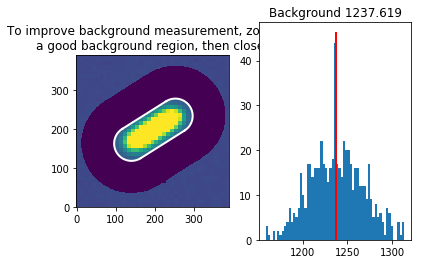

In [15]:
#example of a trailed source
phot(xt,yt,radius=fwhm*1.4,l=(EXPTIME/3600.)*rate/0.185,a=angle,
     skyRadius=4*fwhm,width=6*fwhm,
     zpt=26.0,exptime=EXPTIME,enableBGSelection=True,display=True,
     backupMode="smart",trimBGHighPix=3.)

The SNR function calculates the SNR of the aperture,as well as provide an estiamte of the magnitude/flux uncertainties. Select useBGstd=True if you wish to use the background noise level instead of sqrt of the background level in your uncertainty estimate. **Note: currently, this uncertainty estimate is approximate, good to a few percent. Future improvements will be made to get this a bit more accurate.**

If the photometry radius was an array, then so are the products created using the SNR function.

verbose=True puts some nice terminal output in your face. These values can be accessed with their internal names.

In [16]:
phot.SNR(verbose=True)

#get those values
print(phot.magnitude)
print(phot.dmagnitude)
print(phot.sourceFlux)
print(phot.snr)
print(phot.bg)

   SNR: 1121.6792068307536
   Flux: 767173.3189246762
   Background: 1237.3789471250184
   Background STD: 29.765017423853983
   Num Pixels : 0.0

17.991052570092045
0.0009679560770550616
767173.3189246762
1121.6792068307536
1237.3789471250184


Let's get aperture corrections measured directly from  a star.

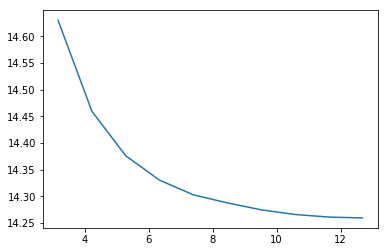

Round aperture correction for a 4xFWHM aperture is 0.184.


In [17]:
phot.computeRoundAperCorrFromSource(goodFits[0,4],goodFits[0,5],num.linspace(1*fwhm,4*fwhm,10),
                                    skyRadius=5*fwhm, width=6*fwhm,displayAperture=False,display=True)
print('Round aperture correction for a 4xFWHM aperture is {:.3f}.'.format(phot.roundAperCorr(1.4*fwhm)))

Finally, let's do some PSF source subtraction. This is only possible with emcee and sextractor installed.

First get the cutout. This makes everything faster later. Also, remove the background, just because.

This also provides an example of how to use zscale **now built into trippy** and astropy.visualization to display an astronomy image using the zscale scaling.

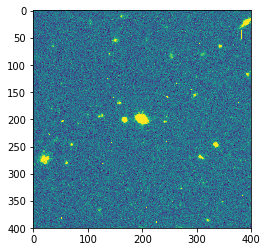

In [18]:
Data = data[int(yt)-200:int(yt)+200,int(xt)-200:int(xt)+200]-phot.bg

(z1,z2) = tzscale.zscale(Data)
normer = interval.ManualInterval(z1,z2)

pyl.imshow(normer(Data))
pyl.show()


Now instantiate the MCMCfitter class, and then perform the fit. Verbose=False will not put anything to terminal. Setting to true will dump the result of each step. Only good idea if you insist on seeing what's happening. Do you trust black boxes?

Set useLinePSF to True if you are fitting a trailed source, False if a point source. 

Set useErrorMap to True if you care to use an estimate of the poisson noise in each pixel during your fit. This produces honest confidence ranges.

I personally like nWalkers=nBurn=nStep=40. To get a reasonable fit however, that's overkill. But to get the best... your mileage will vary.

**This will take a while on a computer. ~1 minute on a modern i5 processor, much longer if you computer is a few years old. You can reduce the number of walkers, nBurn and nStep to ~10 each if you are impatient. This will drop the run time by ~4x**

In [19]:
fitter = MCMCfit.MCMCfitter(goodPSF,Data)
fitter.fitWithModelPSF(200+xt-int(xt)-1,200+yt-int(yt)-1, m_in=1000.,
                       fitWidth=10, 
                       nWalkers=20, nBurn=20, nStep=20, 
                       bg=phot.bg, useLinePSF=True, verbose=False,useErrorMap=False)

Initializing sampler
Executing xy burn-in... this may take a while.
Executing xy production run... this will also take a while.
Best point: [ 1.99227200e+02  1.99307704e+02 -1.21151280e+08]
Executing amplitude burn-in... this may take a while.
Executing amplitude production run... this will also take a while.
Best point: [ 1.23276591e+03 -5.85969550e+06]
Executing xy-amp burn-in... this may take a while.
Executing xy-amp production run... this will also take a while.


Now get the fits results, including best fit and confidence region using the input value. 0.67 for 1-sigma is shown

In [20]:
(fitPars, fitRange) = fitter.fitResults(0.67)
print(fitPars)
print(fitRange)

Best point: [ 1.99198249e+02  1.99276007e+02  1.23284922e+03 -5.85967950e+06]
[ 1.99198249e+02  1.99276007e+02  1.23284922e+03 -5.85967950e+06]
[[199.18696232510138, 199.22792735935738], [199.2917902810964, 199.31038537601992], [1232.0565069073239, 1233.0197654144008]]


Finally, lets produce the model best fit image, and perform a subtraction. Plant will plant a fake source with the given input x,y,amplitude into the input data. If returnModel=True, then no source is planted, but the model image that would have been planted is returned.

remove will do the opposite of plant given input data (it actually just calls plant). 

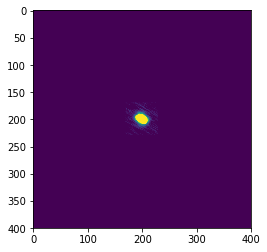

In [21]:
modelImage = goodPSF.plant(fitPars[0],fitPars[1],fitPars[2],Data,addNoise=False,useLinePSF=True,returnModel=True)
pyl.imshow(normer(modelImage))
pyl.show()

Now show the image and the image with model removed for comparison. 

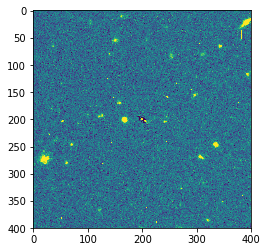

In [22]:
removed = goodPSF.remove(fitPars[0],fitPars[1],fitPars[2],Data,useLinePSF=True)

pyl.imshow(normer(removed))
pyl.show()